## Theory
(taken from the fenics book)

We are solving the Helmholtz equation:
                       

 $$\nabla \times \frac{1}{\mu_r}\nabla \times \boldsymbol{E} - k_0^2 \epsilon_r \boldsymbol{E}=0,$$ with the boundary condition of electric mirrors.
 $$k_0 = \frac{2\pi f_0}{c_0}$$
 
 $$\epsilon_r = (n+\mathrm{i}k)^2$$

The functional is:
$$F(\boldsymbol{E}) = \frac{1}{2} \int_\Omega \left[\frac{1}{\mu_r} \left(\nabla \times \boldsymbol{E}\right)\cdot \left(\nabla \times \boldsymbol{E}\right) - k^2_0 \epsilon_r \boldsymbol{E}\boldsymbol{E}\right]dx$$

In order to find it the vector is split in to the transverse and axial components.

$$\nabla = \nabla_t + \nabla_z,$$
with $$\nabla_t = \hat{e_x}\frac{\partial}{\partial x} + \hat{e_y}\frac{\partial}{\partial y}$$
and $$\nabla_z = \hat{e_z}\frac{\partial}{\partial z}$$
We also assume that the electric field can be split like:
$$\boldsymbol{E}(x,y,z) = \left[E_t(x,y) + \hat{e_z} E_z(x,y) \right] e^{-\beta z}$$
where $\beta$ is the complex propagation constant,
$$\boldsymbol{E}_t = \hat{e_x} E_x + \hat{e_y} E_y$$ and $$ \boldsymbol{E}_{axial} = \hat{e_z} E_z$$

By splitting the $\nabla$ and by substituting the above for the electric field the functional becomes:
                               $$ F_{\beta}(\boldsymbol{E}) =  \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t \times \boldsymbol{E}_{t,\beta}\right) \cdot \left(\nabla_t \times \boldsymbol{E}_{t,\beta}\right) -k^2_0 \epsilon_r E_{t,\beta}E_{t,\beta} \\ + \beta^2 \left[\frac{1}{\mu_r} \left(\nabla_t E_z+\beta E_{t,\gamma}\right)\left(\nabla_t E_z+\beta E_{t,\gamma}\right) - k^2_0 \epsilon_r E_z E_z dx \right]$$

Since the functional is built now the electric field components need to be discetized in order to be calculated. 
The axial component can be discretised by nodal basis functions (Lagrandge) but the transverse need to be by two dimensional curl-conforming vector basis functions(Nedelec).

The electric field in the nedelec space is described by:
$$E_{t} = \sum_{i=1}^{N_{N}} (e_t)_i N_i$$

and the axial in lagrange elements as:

$$E_z = \sum_{i=1}^{N_{L}} (e_z)_i L_i$$
 Where $N_N$ and $N_L$ are the number of nedelec and lagrange elements respectively. $N_i$, $L_i$ are the basis functions and $e_t$, $e_z$ are the equivalent coefficients.

While the cuttoff method is easier to implement it only prety much finds the cuttoff wavenumber (shown in fenics book and in other papers). This is not what is of interest. I am interested in calculating the propagation constants $\beta$ and by extension the effective indices and the Electric field that they equate to.

The matrix eqution to be solved is

$$\begin{bmatrix}
    A_{tt}       & 0 \\
    0       & 0 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix} = -\beta^2
\begin{bmatrix}
    B_{tt}       & B_{tz} \\
    B_{zt}       & B_{zz} 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix}
$$

Where $$A_{tt} = S_{tt} - k^2_0 T_{tt} = \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t \times N_i \right) \left(\nabla_t \times N_j \right)dx \\ - k^2_0 \int_{\omega} \epsilon_r N_i N_jdx$$

$$B_{zz} = S_{zz} - k^2_0 T_{zz} = \int_{\Omega} \frac{1}{\mu_r} \left(\nabla_t L_i \right) \left(\nabla_t L_j \right)dx \\ - k^2_0 \int_{\omega} \epsilon_r L_i L_j dx$$

$$ B_{tt} = \int_{\Omega} \frac{1}{\mu_r} N_i \cdot  N_j dx$$

$$ B_{tz} = \int_{\Omega} \frac{1}{\mu_r} N_i \cdot  \nabla_t L_j dx$$

$$ B_{zt} = \int_{\Omega} \frac{1}{\mu_r} \nabla_t L_i \cdot  N_j dx$$

### Code
Import the required modules

In [10]:
%matplotlib notebook
from __future__ import division#, print_function
import numpy as np
from scipy.constants import c,pi
from scipy.sparse.linalg import eigs, eigsh
from scipy.linalg import eig
from scipy.sparse import csr_matrix, lil_matrix, csc_matrix
import matplotlib.pyplot as plt
from matplotlib import tri
from scipy.integrate import simps
import os
from matplotlib.colors import from_levels_and_colors
from dolfin import *
import time
from functions_dispersion_analysis import *

The box domain:

In [19]:
a = 2e-4
b = 2e-4

Inputs of the problem

In [20]:
mu_r = 1.0 
lamda = 1.55e-6
r_core = 1e-5 # radius of core
r_clad = 10e-5 #radius of the fibre
nclad = 1.444#- 0.1e-4j# ref index of cladding
ncore = 1.445 - 1e-4j # ref index of core
#neff_g = 1.4445 # Guess of the modes
num= 10   # The number of modes guess 
neff_g= 1.4444696341894405-7.8562093865609619e-05
mesh_refinement = 0 # number of times to uniformly refine the mesh (used for convergence plots and better results)

from testing.Single_mode_fibre.Single_mode_theoretical import *
neff_th, Aeff_th = main_test(ncore,nclad,lamda,r_core,r_clad)
print(neff_th,Aeff_th)

In [21]:
k = is_loss(ncore,nclad)
if k ==0:
    V = 2*pi/lamda*r_core*(ncore**2 - nclad**2)**0.5
    print(V)
k0 = 2*pi/lamda

In [22]:

def is_loss(ncore,nclad):
    if (nclad.imag,ncore.imag) == (0,0):
        k = 0
    else:
        k = 1
    return k


In [23]:
def ref(x,values = np.zeros(1)):
    point = (x[0]**2+ x[1]**2)**0.5
    if  point<= r_core:
        values[0] = ncore.real**2 - ncore.imag**2
    elif point > r_core and point <= r_clad:
        values[0] = nclad.real**2 - nclad.imag**2
    else:
        values[0] = 1.
    return values

def extinction(x,values = np.zeros(1)):
    point = (x[0]**2+ x[1]**2)**0.5
    if  point<= r_core:
        values[0] = 2*ncore.imag*ncore.real
    elif point > r_core and point <= r_clad:
        values[0] = 2*nclad.imag*ncore.real
    else:
        values[0] = 0
    return values

In [24]:
%matplotlib inline

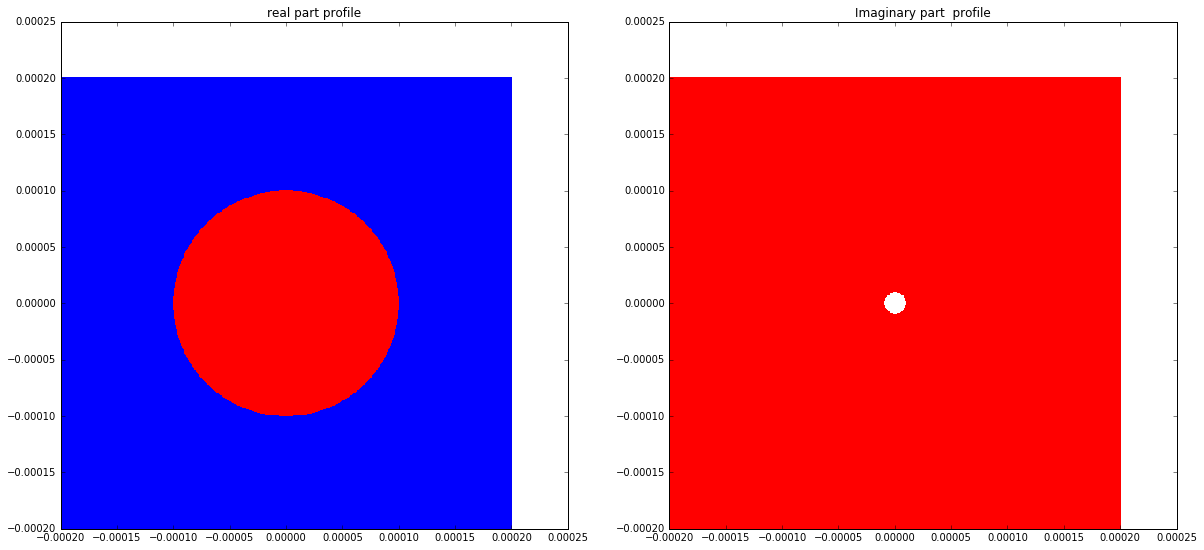

In [25]:
x = np.linspace(-a,a,512)
y = np.linspace(-b,b,512)
n_prof,k_prof = geometry_plot(x,y,a,b,ref,extinction,nclad,ncore,r_core,r_clad)


In [26]:
class epsilon_real(Expression):
    def eval(self, values, x):
       values = ref(x,values)

class epsilon_imag(Expression):
    def eval(self, values, x):
       values = extinction(x,values)

## Mesh

Load the gmsh file and if asked for refine the mesh.

In [27]:
mesh = gmesh_mesh_new("geometry_new.geo",a,b,r_core,r_clad,mesh_refinement,lamda,1)

Info    : Running 'gmsh fenics_mesh/Output.geo -2 -o fenics_mesh/output_small.msh' [Gmsh 2.12.0, 1 node, max. 1 thread]
Info    : Started on Wed Jun 29 12:17:03 2016
Info    : Reading 'fenics_mesh/Output.geo'...
Info    : Done reading 'fenics_mesh/Output.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Meshing curve 4 (Circle)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Meshing curve 7 (Circle)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Circle)
Info    : Meshing curve 11 (Circle)
Info    : Meshing curve 12 (Circle)
Info    : Meshing curve 13 (Circle)
Info    : Meshing curve 14 (Circle)
Info    : Meshing curve 15 (Circle)
Info    : Meshing curve 16 (Circle)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Don

#mesh = gmesh_mesh("original_geometry.geo",a,b,r_core,r_clad,19)
#mesh = gmesh_mesh_new("geometry_new.geo",a,b,r_core,r_clad,mesh_refinement,r_core)
#plot(mesh,interactive=True)

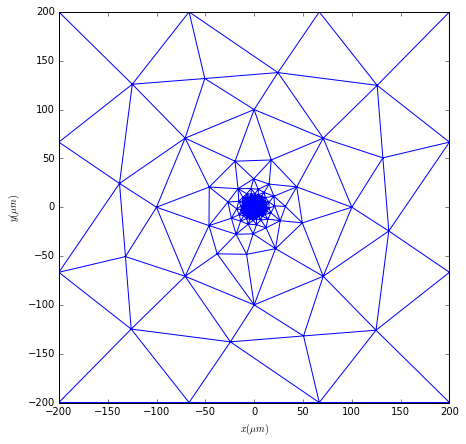

In [28]:
n = mesh.num_vertices()
d = mesh.geometry().dim()

# Create the triangulation
mesh_coordinates = mesh.coordinates().reshape((n, d))
triangles = np.asarray([cell.entities(0) for cell in cells(mesh)])
triangulation = tri.Triangulation(mesh_coordinates[:, 0],
                                  mesh_coordinates[:, 1],
                                  triangles)

triangulation.x *=1e6 
triangulation.y *=1e6 
# Plot the mesh
fig = plt.figure(figsize=(7.0, 7.0))
plt.triplot(triangulation)
plt.xlabel(r'$x(\mu m)$')
plt.ylabel(r'$y(\mu m)$')

plt.savefig('mesh.png',bbox_inches='tight')
plt.show()

### Define the orders of the fucntion spaces for vector and nodal basis functions

In [29]:
vector_order = 3
nodal_order = 3

Define the test and trial functions from the combined space here N_i and N_j are Nedelec basis functions and L_i and L_j are Lagrange basis functions

## Creating the matrix equation.

$$\begin{bmatrix}
    A_{tt}       & 0 \\
    0       & 0 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix} = -\beta^2
\begin{bmatrix}
    B_{tt}       & B_{tz} \\
    B_{zt}       & B_{zz} 
\end{bmatrix}\begin{bmatrix}
    e_t \\
    e_z      
\end{bmatrix}
$$

Define the forms (matrix elements) for dispersion analysis into the basis functions

In [32]:
combined_space, A,B, A_complex,B_complex = Matrix_creation(mesh,epsilon_real,epsilon_imag,mu_r,k,k0,vector_order,nodal_order)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


post-multiplication by dx will result in integration over the domain of the mesh at assembly time

## Implement boundary conditions

In [33]:
A,B,A_complex,B_complex,electric_wall = Mirror_boundary(mesh,combined_space,A,B,A_complex,B_complex,k)
#free_dofs = boundary_marker_locator(A,electric_wall)
free_dofs = boundary_marker_locator(A,electric_wall)

### Free the vectors and make numpy arrays to solve with scipy

Find what part of the vectors are not ascociated with the boundary values

In [34]:
A.size(0)

11707

### Solve the eigenvalue system using scipy.linalg.eig

In [35]:
eigen,ev,A_np,B_np = find_eigenvalues(A,B,A_complex,B_complex,neff_g,20,k0,free_dofs,k,sparse_=True)

sparse eigenvalue time


dot_sparse = csc_matrix.dot
eigen, ev =scipy_sparse_eigensolver(dot_sparse(conj_trans(B_np),A_np),dot_sparse(conj_trans(B_np),B_np),neff_g,70,k0)

Find $\beta$ from the eigenvalue.

neff_g = 1.4444696250032485-7.8560918745118053e-5j

In [36]:
beta =1j*(eigen)**0.5 
beta = np.abs(np.real(beta)) -1j*np.imag(beta)

sort the calculated values

In [37]:
sort_index = np.argsort(beta.imag)[::-1]

In [38]:
propagating_modes = np.where(((beta[sort_index]/k0).real>nclad.real) & ((beta[sort_index]/k0).real<ncore))
propagating_modes = propagating_modes[0][:]

Print the first four effective indices. ((1.44446963419-7.85620938656e-05j))

In [39]:
print("The effective index of the modes are:")
print(beta[sort_index][propagating_modes]/k0)

The effective index of the modes are:
[ 1.44489459-0.00137752j  1.44486770-0.00148415j]


In [40]:
neff_th
[ 1.44447755 -7.91159282e-05j  1.44447755 -7.91160349e-05j]
[1.44447347 -7.88401221e-05j,  1.44447347 -7.88402002e-05j]

SyntaxError: invalid syntax (<ipython-input-40-3a86c69b219e>, line 2)

In [41]:
neff = beta[sort_index][propagating_modes]/k0

Comsol : 1.4444696250032485-7.856091874511805E-5i

### Plot the results

In [42]:
from scipy.io import savemat,loadmat

In [44]:
size1,size2 = 512,512
min_max = (-3*r_core,3*r_core,-3*r_core,3*r_core)

In [45]:
mode0 = modes(0,size1,size2,min_max,propagating_modes,beta,sort_index,k0)
mode0.electric_field_full(k,A,ev,sort_index,free_dofs,combined_space)


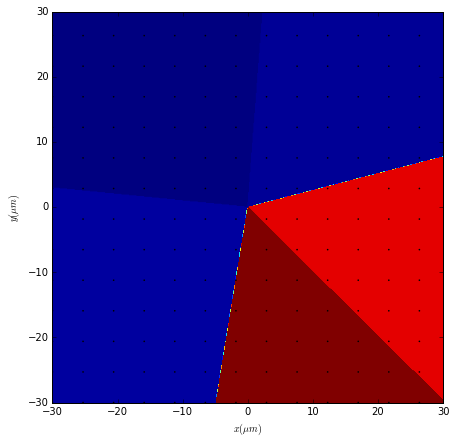

In [46]:
mode0.plot_electric_field(scales = 2*150000,sp=40,cont_scale=700)

In [ ]:
N_complex

In [46]:
D = loadmat('convergence'+str(3)+'.mat')

In [47]:
D

{'Aeff_simps': array([[  5.40352405e-11,   8.31579498e-11,   1.01865374e-10,
           4.16698204e-10,   4.16698318e-10,   2.30471865e-10,
           4.49677356e-10]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Jun 28 18:16:45 2016',
 '__version__': '1.0',
 'cells': array([[7926]]),
 'neff': array([[ 1.44482516 -1.70249321e-13j,  1.44453752 -2.54676100e-15j,
          1.44447296 -1.48821896e-14j,  1.44447160 -7.87068911e-05j,
          1.44447160 -7.87068585e-05j,  1.44419644 -3.19344512e-13j,
          1.44407302 -3.06190742e-10j]])}

In [23]:
D

{'Aeff_simps': array([[  4.16985579e-10,   4.16985710e-10]]),
 '__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Jun 27 19:59:49 2016',
 '__version__': '1.0',
 'cells': array([[5966]]),
 'neff': array([[ 1.4444722 -7.87506834e-05j,  1.4444722 -7.87506487e-05j]])}

In [103]:
from scipy.io import loadmat
def plot_convergence(x,y,name,savename):
    fig = plt.figure(figsize=(10,7))
    plt.plot(x,y,'-o')
    plt.xlabel(r'$N_c$',fontsize='18')
    plt.ylabel(name,fontsize='18')
    plt.savefig(savename+'.eps',bbox_inches = 'tight')
    plt.savefig(savename+'.png',bbox_inches = 'tight')
    plt.show()
N_complex = []
A = []
I = [0,3,0,4]
C = []
for refine in range(4):
    D = loadmat('convergence'+str(refine)+'.mat')
    i = I[refine]
    A.append(D['Aeff_simps'][0][i])
    #if refine ==2:
    #    N_complex.append(1.44446548 -7.87245719e-05j)
    #else:
    N_complex.append(D['neff'][0][i])
    #I.append(i)
    C.append(D['cells'][0][0])


In [104]:
Aeff_th

4.160317256055599e-10

In [105]:
N_complex = np.asanyarray(N_complex)
A = np.asanyarray(A)

In [106]:
dN_real = 100*np.abs(N_complex.real - neff_th.real)/np.abs(neff_th.real)
dN_imag = 100*np.abs(N_complex.imag - neff_th.imag)/np.abs(neff_th.imag)
dA = 100*np.abs(A - Aeff_th)/np.abs(A)

<IPython.core.display.Javascript object>


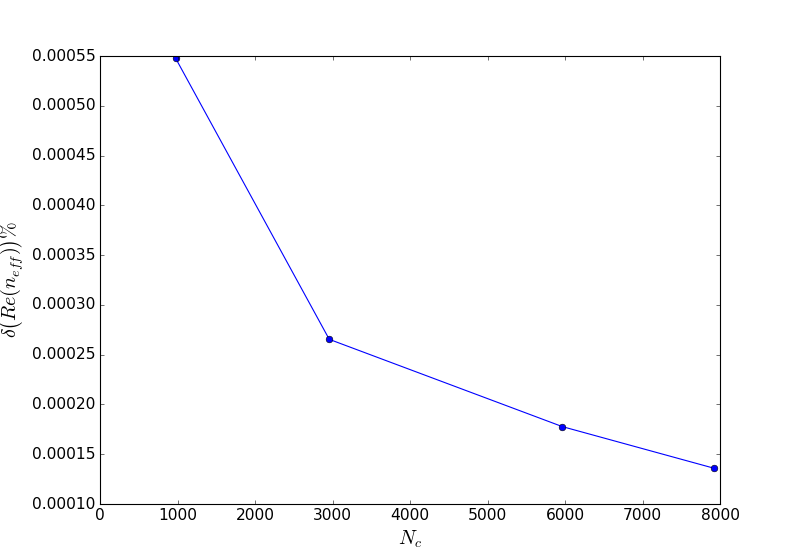

<IPython.core.display.Javascript object>


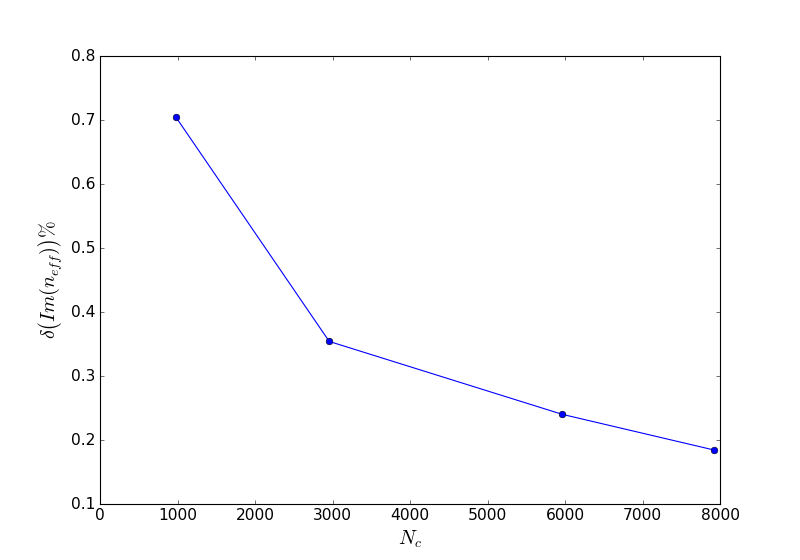

<IPython.core.display.Javascript object>


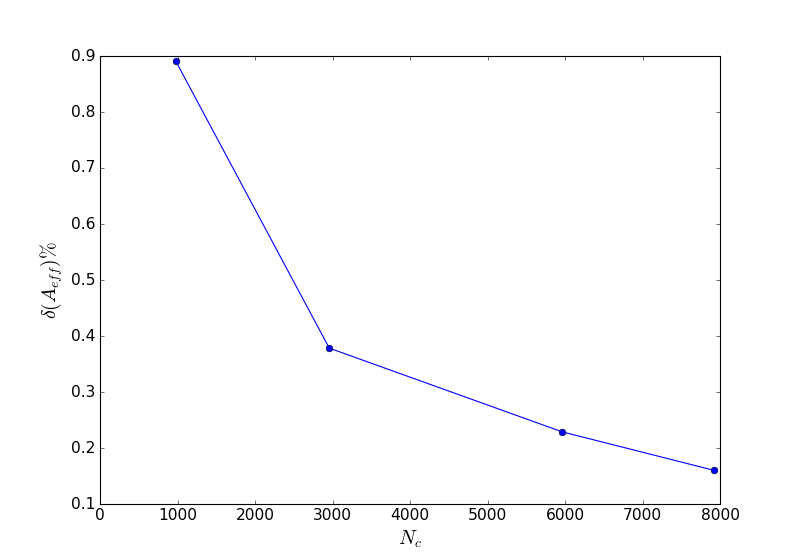

In [107]:
plot_convergence(C,dN_real,r'$\delta \left(Re(n_{eff})\right)\%$','neff_re_conv')
plot_convergence(C,dN_imag,r'$\delta \left(Im(n_{eff})\right)\%$','neff_im_conv')
plot_convergence(C,dA,r'$\delta \left(A_{eff}\right)\%$','A_eff_conv')

In [ ]:

class modes(object):
    def __init__(self,mode,size1,size2,min_max,propagating_modes,beta,sort_index,k0):
        self.mode = mode
        self.mode_idx = propagating_modes[self.mode]
        self.neff = beta[sort_index][self.mode_idx]/k0
        
        self.xmin, self.xmax,self.ymin,self.ymax = min_max
        
        self.x = np.linspace(self.xmin,self.ymax,size1)
        self.y = np.linspace(self.ymin,self.ymax,size2)
        self.E = None
        self.E_axial = None


    def dolfin_functions(self,k,A,ev,sort_index,free_dofs,combined_space):
        #post-process the coefficients to map back to the full matrix
        coefficiants_global = np.zeros(A.size(0),dtype=np.complex)
        coefficiants_global[free_dofs] = ev[:,sort_index[self.mode_idx]]
        #Create a Function on the combined space
        mode_re = Function(combined_space)
        mode_im = Function(combined_space)
        #Assign the coefficients of the function to the calculated values
        mode_re.vector().set_local(np.real(coefficiants_global))
        mode_im.vector().set_local(np.imag(coefficiants_global))
        #Split the function into the parts in each of the functions spaces in combined_space
        #This is done using DOLFINs Function.split()
        (TE_re,TM_re) = mode_re.split()
        (TE_im,TM_im) = mode_im.split()
        self.TE_re = TE_re
        self.TE_im = TE_im
        self.TM_re = TM_re
        self.TM_im = TM_im
        return None#TE_re,TE_re,TM_re,TM_im

    def effective_area(self,k,A,ev,sort_index,free_dofs,combined_space,lim):
        try:
            temp = self.TE_re
        except AttributeError:
            self.dolfin_functions(k,A,ev,sort_index,free_dofs,combined_space)
            pass
        integrand1 = dblquad(self.Eabs2, -lim, lim, lambda x: -lim,lambda x: lim)
        integrand2 = dblquad(lambda y,x: self.Eabs2(y,x)**2, -lim, lim, lambda x: -lim,lambda x: lim)
        
        self.Aeff =  integrand1[0]**2/integrand2[0]


    def Eabs2(self,y,x):
        E_ = self.Efun(y,x)
        return (E_[0]*E_[0].conjugate() + E_[1]*E_[1].conjugate()).real
    def Efun(self,y,x):
        point = Point(x,y)
        E = self.TE_re(point)+1j*self.TE_im(point)
        return E[0],E[1]


    def effective_area_simps(self,k,A,ev,sort_index,free_dofs,combined_space):
        if self.E ==None:
            self.electric_field_full(k,A,ev,sort_index,free_dofs,combined_space)
        
        integrand1 = (self.E[:,:,0].conjugate()*self.E[:,:,0] + self.E[:,:,1].conjugate()*self.E[:,:,1]).real   
        Over = integration2d_simps(self.x,self.y,integrand1)
            
        integrand2 = integrand1**2
        under = integration2d_simps(self.x,self.y,integrand2)
        self.Aeff = Over**2/under    
        return Over**2/under
    def electric_field_full(self,k,A,ev,sort_index,free_dofs,combined_space):
        """
        Releases the electric field from the calculated eigenvalus and eigen vectors
        
        Returns::
        E[size,size,2],E_axial(Ez)
        """
        try:
            temp = self.TE_re
        except AttributeError:
            self.dolfin_functions(k,A,ev,sort_index,free_dofs,combined_space)
            pass
        
        E = np.zeros([len(self.x),len(self.y),2],dtype = np.complex)
        E_axial = np.zeros([len(self.x),len(self.y)], dtype= np.complex)
        for i,xx in enumerate(self.x):
            for j,yy in enumerate(self.y):
                point = Point(xx,yy)
                E[i,j,:]     =  self.TE_re(point) + 1j*self.TE_im(point)
                E_axial[i,j] =  self.TM_re(point) + 1j*self.TM_im(point)
        self.E = E
        self.E_axial = E_axial
        self.mode_field = np.transpose((np.abs(self.E[:,:,0])**2 + np.abs(self.E[:,:,1])**2+np.abs(self.E_axial[:,:])**2)**0.5)
        maxi = np.max(self.mode_field)
        self.mode_field /=maxi

        return None    

    def plot_electric_field(self,sp=10,scales = 500000,cont_scale=90,**kwrds):

        fig = plt.figure(figsize=(7.0, 7.0))
        xplot = self.x*1e6
        yplot = self.y*1e6
        X,Y = np.meshgrid(xplot,yplot)
        try:
            plt.contourf(X,Y,self.mode_field,cont_scale)
        except AttributeError:
             raise NotImplementedError("interpolate before plotting")

        plt.quiver(X[::sp,::sp], Y[::sp,::sp], np.real(self.E[::sp,::sp,0]), np.real(self.E[::sp,::sp,1]),scale = scales,headlength=7)
        plt.xlabel(r'$x(\mu m)$')
        plt.ylabel(r'$y(\mu m)$')
        #plt.title(r'mode$=$'+str(self.mode)+', '+'  $n_{eff}=$'+str(self.neff.real)+str(self.neff.imag)+'j')
        plt.savefig('mode'+str(self.mode)+'.eps',bbox_inches ='tight')
        D = {}
        D['X'] = X
        D['Y'] = Y
        D['Z'] = self.mode_field
        D['u'] = np.real(self.E[::sp,::sp,0])
        D['v'] = np.real(self.E[::sp,::sp,1])
        D['scale'] = scales
        D['cont_scale'] = 90
        D['sp'] = sp
        savemat('mode'+str(self.mode)+'.mat',D)
        return None


In [ ]:
plt.savetxt?

In [ ]:
print(mode0.E.shape)

In [ ]:
mode0.effective_area(k,A,ev,sort_index,free_dofs,combined_space,r_clad)

In [ ]:
mode0.Aeff

In [ ]:
mode0.effective_area_simps(k,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
nclad

In [ ]:
C

In [ ]:
mode0.Eabs2(y[0],x[0])

In [ ]:
E_ = mode0.Efun(y[0],x[0])

In [ ]:
np.abs(mode0.Efun(y[0],x[0]))**2

In [ ]:
mode1 = modes(0,size1,size2,min_max,propagating_modes,beta,sort_index,k0)
mode1.electric_field_full(k,A,ev,sort_index,free_dofs,combined_space)


In [ ]:
mode1.effective_area(k,A,ev,sort_index,free_dofs,combined_space,r_clad)

In [ ]:
mode1.plot_electric_field(scales = 90000,sp=40)

# Tests

Effective area

In [ ]:
def effective():
    

In [ ]:
if aj:
    print"hello"

def electric_field_full(mode_idx,x,y,k,A,ev,sort_index,free_dofs,combined_space):
    """
    Releases the electric field from the calculated eigenvalus and eigen vectors
    
    Returns::
    E[size,size,2],E_axial(Ez)
    """

    #post-process the coefficients to map back to the full matrix
    coefficiants_global = np.zeros(A.size(0),dtype=np.complex)
    coefficiants_global[free_dofs] = ev[:,sort_index[mode_idx]]
    #Create a Function on the combined space
    mode_re = Function(combined_space)
    mode_im = Function(combined_space)
    #Assign the coefficients of the function to the calculated values
    mode_re.vector().set_local(np.real(coefficiants_global))
    mode_im.vector().set_local(np.imag(coefficiants_global))
    #Split the function into the parts in each of the functions spaces in combined_space
    #This is done using DOLFINs Function.split()
    (TE_re,TM_re) = mode_re.split()
    (TE_im,TM_im) = mode_im.split()

    E = np.zeros([len(x),len(y),2],dtype = np.complex)
    E_axial = np.zeros([len(x),len(y)], dtype= np.complex)
    for i,xx in enumerate(x):
        for j,yy in enumerate(y):
            point = Point(xx,yy)
            E[i,j,:]    =  TE_re(point) + 1j*TE_im(point)
            E_axial[i,j] = TM_re(point) + 1j*TM_im(point)
    return E,E_axial

In [ ]:
x = np.linspace(-r_clad,r_clad,512)
y = np.linspace(-r_clad,r_clad,512)

In [ ]:
delx = x[1] - x[0]
dely = y[1] - y[0]

In [ ]:
En,E_axialn = electric_field_full(propagating_modes[0],x,y,k,A,ev,sort_index,free_dofs,combined_space)
Em,E_axialm = electric_field_full(propagating_modes[1],x,y,k,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
np.max(np.gradient(En[:,:,0],delx,dely)[0] +np.gradient(En[:,:,1],delx,dely)[1] + np.gradient(E_axial))

In [ ]:
np.max(np.gradient(En[:,:,0])[2])

In [ ]:
def overlap_simps(En,E_axialn,Em,E_axialm,x,y):
    integrand1 = np.conjugate(En[:,:,0])*Em[:,:,0] + np.conjugate(En[:,:,1])*Em[:,:,1] + np.conjugate(E_axialn[:,:])*E_axialm[:,:]
    Over = integration2d_simps(x,y,integrand1)
    
    integrand2 = np.abs(En[:,:,0])**2 + np.abs(En[:,:,1])**2 + np.abs(E_axialn[:,:])**2
    under1 = integration2d_simps(x,y,integrand2)
       
    integrand3 = np.abs(Em[:,:,0])**2 + np.abs(Em[:,:,1])**2 + np.abs(E_axialm[:,:])**2
    under2 = integration2d_simps(x,y,integrand3)
    print(np.max(integrand1))#,integrand2,integrand3)
    print(Over,under1,under2)
    return np.abs(Over)**2/(under1*under2)


In [ ]:
integrand1 = np.conjugate(En[:,:,0])*Em[:,:,0] + np.conjugate(En[:,:,1])*Em[:,:,1] + np.conjugate(E_axialn[:,:])*E_axialm[:,:]

In [ ]:
X,Y = np.meshgrid(x,y)
plt.contourf(X,Y,integrand1)
plt.xlim(-r_core,r_core)
plt.ylim(-r_core,r_core)
plt.colorbar()

In [ ]:
overlap_simps(En,E_axialn,Em,E_axialm,x,y)

In [ ]:
from testing.Single_mode_fibre import *


In [ ]:
effective_area_simps(En,E_axialn,x,y)

In [ ]:
effective_area_simps(Em,E_axialm,x,y)

In [ ]:
#Overlaps_simps(3,4,propagating_modes,x,y)
Overlaps_simps(3,4,propagating_modes,x,y,r_core,r_clad,k,beta,k0,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
import sympy.vector.coordsysrect

In [ ]:
from sympy.vector import CoordSysCartesian, divergence,curl
R = CoordSysCartesian('R')
v1 = R.x*R.y*R.z * (R.i+R.j+R.k)
divergence(v1, R)
v2 = 2*R.y*R.z*R.j
divergence(v2, R)

In [ ]:
E = R.x*E[:,:,0] +R.y*E[:,:,1]+ R.z*E_axial

In [ ]:
np.diff?

In [ ]:
Overlaps_simps(3,3,propagating_modes,x,y,r_core,r_clad,k,beta,k0,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
Overlaps_simps(4,4,propagating_modes,x,y,r_core,r_clad,k,beta,k0,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
div(combined_space)

In [ ]:
E,E_axial = electric_field_full(mode_idx,x,y,k,A,ev,sort_index,free_dofs,combined_space)

In [ ]:
def divergence(F):
    """ compute the divergence of n-D scalar field `F` """
    return reduce(np.add,np.gradient(F))

In [ ]:
e_r = n_prof +1j*k_prof

In [ ]:
div = np.gradient(e_r)

In [ ]:
np.shape(e_r)

In [ ]:
np.shape(div)

In [ ]:
beta

In [ ]:
alpha = np.linspace(-5,5,100)
beta = np.copy(alpha)
AR,BR =np.meshgrid(alpha,beta)
alpha,beta = AR,BR
gama = 1/(AR**2 + BR**2)

plt.contourf(AR,BR,gama)

In [ ]:
plt.contourf(AR,BR,divergence(gama))
plt.colorbar()

In [ ]:
np.max(divergence(gama))

In [ ]:
plt.contourf(X,Y,divergence(E[:,:,0]))#+divergence(np.dot(e_r,E[:,:,1])))#+divergence(E_axial))
plt.colorbar()

In [ ]:
sympy.__version__

In [ ]:
import sympy

In [ ]:
coefficiants_global = np.zeros(A.size(0),dtype=np.complex)
coefficiants_global[free_dofs] = ev[:,sort_index[mode_idx]]
mode_re = Function(combined_space)
mode_im = Function(combined_space)
mode_re.vector().set_local(np.real(coefficiants_global))
mode_im.vector().set_local(np.imag(coefficiants_global))
(TE_re,TM_re) = mode_re.split()
(TE_im,TM_im) = mode_im.split()
E = np.zeros([len(x),len(y),2],dtype = np.complex)
E_axial = np.zeros([len(x),len(y)], dtype= np.complex)
for i,xx in enumerate(x):
    for j,yy in enumerate(y):
        point = Point(xx,yy)
        E[i,j,:]    =  TE_re(point) + 1j*TE_im(point)
        E_axial[i,j] = TM_re(point) + 1j*TM_im(point)


In [ ]:
TE_re

In [ ]:
from scipy.misc import derivative


In [ ]:
derivative?

In [ ]:
y = np.empty_like(x)
y[:-1] = (x[1:] - x[:-1]) / delx
y[-1] = -x[-1] / delx

In [ ]:
delx = x[1]- x[0]

In [ ]:
y = np.empty_like(x)

In [ ]:
diver = np.gradient(np.dot(e_r,E[:,:,0]))[1]+np.gradient(np.dot(e_r,E[:,:,1]))[1]+np.gradient(np.dot(e_r,E_axial))[0]

In [ ]:
diver2 = np.gradient(E[:,:,0])[0]+np.gradient(E[:,:,1])[0]+np.gradient(E_axial)[0]

In [ ]:
np.gradient(E[:,:,1])

In [ ]:
np.linalg.norm(diver2)

In [ ]:
plt.contourf(diver2)
plt.colorbar()

In [ ]:
np.dot(e_r,E[:,:,0])

In [ ]:
np.gradient(np.array([[1, 2, 6], [3, 4, 5]], dtype=np.float))

In [ ]:
from netCDF4 import Dataset      
import numpy as np      
import matplotlib.pyplot as plt 

GridSat = Dataset('analysis_20040713_v11l30flk.nc4','r',format='NETCDF4')
missing_data = -9999.0
lat = GridSat.variables['lat']   
lat = lat[:]     
lat[np.where(lat==missing_data)] = np.nan  
lat[np.where(lat > 90.0)] = np.nan     

lon = GridSat.variables['lon']   
lon = lon[:]                
lon[np.where(lon==missing_data)] = np.nan


uwind_data = GridSat.variables['uwnd']  
uwind = GridSat.variables['uwnd'][:]
uwind_sf = uwind_data.scale_factor   
uwind_ao = uwind_data.add_offset
miss_uwind = uwind_data.missing_value

uwind[np.where(uwind==miss_uwind)] = np.nan    


vwind_data = GridSat.variables['vwnd']  
vwind = GridSat.variables['vwnd'][:]
vwind_sf = vwind_data.scale_factor    
vwind_ao = vwind_data.add_offset
miss_vwind = vwind_data.missing_value

vwind[np.where(vwind==miss_vwind)] = np.nan  


uwind = uwind[2,:,:]
vwind = vwind[2,:,:]  

dx = 28400.0 # meters calculated from the 0.25 degree spatial gridding 
dy = 28400.0 # meters calculated from the 0.25 degree spatial gridding 

#dv_dx, dv_dy = np.gradient(vwind, [dx,dy])
#du_dx, du_dy = np.gradient(uwind, [dx,dy])
v_dx, dv_dy = np.gradient(vwind, dx,dy)
du_dx, du_dy = np.gradient(uwind, dx,dy)

In [ ]:
from netCDF4 import Dataset   

In [ ]:
E_large = np.zeros([512,512,3],dtype=np.complex)

In [ ]:
E_large[:,:,0:2] = E
E_large[:,:,-1] =E_axial

In [ ]:
dexdx,dexdy,dexdz = np.gradient(E_large,x[1]-x[0],x[1]-x[0],x[1]-x[0])[0][:,:,0], np.gradient(E_large,1,1,1)[0][:,:,1], np.gradient(E_large,1,1,1)[0][:,:,2]

In [ ]:
deydx,deydy,deydz = np.gradient(E_large,x[1]-x[0],x[1]-x[0],x[1]-x[0])[1][:,:,0], np.gradient(E_large,1,1,1)[1][:,:,1], np.gradient(E_large,1,1,1)[1][:,:,2]

In [ ]:
dezdx,dezdy,dezdz = np.gradient(E_large,x[1]-x[0],x[1]-x[0],x[1]-x[0])[2][:,:,0], np.gradient(E_large,1,1,1)[2][:,:,1], np.gradient(E_large,1,1,1)[2][:,:,2]

In [ ]:
dive =dexdx + deydy +dezdz

In [ ]:
plt.contourf(dive)